In [2]:
import pandas as pd
import numpy as np
import pystan
import json

In [3]:
%ls predictions

data.json                  data_best_models.json.bak
data_best_models.json      external_valid.csv


In [4]:
with open("predictions/data_best_models.json", "r") as read_file:
    players_data_all = json.load(read_file)

In [5]:
external_valid = pd.read_csv("predictions/external_valid.csv")

In [6]:
external_valid.head()

,twitch,userid,rankgrp01,rankgrp02,rankgrp03,rankgrp04
0,1bennyy,1529403,NaN,C,NaN,NaN
1,1bondi,1009008,B,A,NaN,NaN
2,1cojomo,1220090,NaN,A,NaN,NaN
3,1fxde,1287011,A,A,A,NaN
4,1herocs,1166580,NaN,A,A,NaN


In [7]:
len(players_data_all['logits_aud'])

2340

In [8]:
players_data = {}
for key, elem in players_data_all.items():
    if key in ["id"]:
        continue
    else:
        players_data[key]=elem

In [9]:
players_data["P"]

425

In [10]:
("id" in players_data)

False

In [11]:
players_code = """
data {
    int<lower=0> P_obs; // number of players with known ranks
    int<lower=0> P_new; // number of players without known ranks
    int<lower=0> P; // number of all players
    
    int<lower=0> L_aud; // number of logits based on audio
    int<lower=0> L_txt; // number of logits based on chat text
    int<lower=0> L_tmp; // number of logits based on chat temporal
    int<lower=0> L_img; // number of logits based on images
    int<lower=0> L_mov; // number of logits based on flow
    
    int<lower=0, upper=1> r[P_obs]; // observed ranks
    int<lower=0> seg_aud[P]; //number of audio logits per player
    int<lower=0> seg_txt[P] ; //number of chat txt logits per player
    int<lower=0> seg_tmp[P] ; //number of chat tmp logits per player
    int<lower=0> seg_img[P] ; //number of video-image logits per player
    int<lower=0> seg_mov[P] ; //number of video-flow logits per player
    
    vector[L_aud] logits_aud; // logits based on audio 
    vector[L_txt] logits_txt; // logits based on chat text
    vector[L_tmp] logits_tmp; // logits based on chat tmp
    vector[L_img] logits_img; // logits based on images
    vector[L_mov] logits_mov; // logits based on flow
}
parameters {

    real mu_aud; //grand mean of the audio modality component of the skill
    real mu_txt; //grand mean of the text modality component of the skill
    real mu_tmp; //grand mean of the temporal modality component of the skill
    real mu_img; //grand mean of the spatial modality component of the skill
    real mu_mov; //grand mean of the motion modality component of the skill
    
    real<lower=0> tau_aud; //intrapersonal variability of audio output
    real<lower=0> tau_txt; //intrapersonal variability of txt output
    real<lower=0> tau_img; //intrapersonal variability of img output
    real<lower=0> tau_mov; //intrapersonal variability of mov output
    
    vector[P] eta_aud; // person-specific audio modality skill
    vector[P] eta_txt; // person-specific text modality skill
    vector[P] eta_tmp; // person-specific temporal modality skill
    vector[P] eta_img; // person-specific spatial modality skill
    vector[P] eta_mov; // person-specific motion modality skill
    
    real<lower=0> sigma_aud; //noise of the audio model
    real<lower=0> sigma_txt; //noise of the chat text model
    real<lower=0> sigma_tmp; //noise of the chat temporal model
    real<lower=0> sigma_img; //noise of the chat text model
    real<lower=0> sigma_mov; //noise of the chat temporal model
}
transformed parameters {
    vector[P] eta;
    
    for (i in 1:P) {
        eta[i] = 0.2 *(eta_aud[i] + eta_tmp[i] + eta_txt[i] + eta_img[i] + eta_mov[i]);
    }
}
model {

    int pos_aud;
    int pos_txt;
    int pos_tmp;
    int pos_img;
    int pos_mov;
       
    tau_aud ~ gamma(2,0.1); //prior on intrapersonal variability of audio output
    tau_txt ~ gamma(2,0.1); //prior on intrapersonal variability of txt output
    tau_img ~ gamma(2,0.1); //prior on intrapersonal variability of img output
    tau_mov ~ gamma(2,0.1); //prior on intrapersonal variability of mov output

    mu_aud ~ normal(0, 1000); //vague hyperprior on grand mean for audio modality   
    sigma_aud ~ gamma(2,0.1); // vague prior on grand variability for audio modality 
    eta_aud ~ normal(mu_aud, sigma_aud);
    
    mu_txt ~ normal(0, 1000); //vague hyperprior on grand mean for text modality     
    sigma_txt ~ gamma(2,0.1); // vague prior on grand variability for text modality
    eta_txt ~ normal(mu_txt, sigma_txt);

    mu_tmp ~ normal(0, 1000); //vague hyperprior on grand mean for tmp modality     
    sigma_tmp ~ gamma(2,0.1); // vague prior on grand variability for tmp modality
    eta_tmp ~ normal(mu_tmp, sigma_tmp);
    
    mu_img ~ normal(0, 1000); //vague hyperprior on grand mean for image modality     
    sigma_img ~ gamma(2,0.1); // vague prior on grand variability for image modality
    eta_img ~ normal(mu_img, sigma_img);
    
    mu_mov ~ normal(0, 1000); //vague hyperprior on grand mean for motion modality    
    sigma_mov ~ gamma(2,0.1); // vague prior on grand variability for motion modality
    eta_mov ~ normal(mu_mov, sigma_mov);

    r ~ bernoulli_logit(eta[1:P_obs]); //Likelihood
    
    pos_aud = 1;
    pos_txt = 1;
    pos_tmp = 1;
    pos_img = 1;
    pos_mov = 1;
    
    for (i in 1:P) {
        
        if (seg_aud[i] > 0) 
            segment(logits_aud,pos_aud,seg_aud[i]) ~ normal(eta_aud[i],tau_aud); //Likelihood
            pos_aud = pos_aud + seg_aud[i];
        
        if (seg_txt[i] > 0)
            segment(logits_txt,pos_txt,seg_txt[i]) ~ normal(eta_txt[i],tau_txt); //Likelihood
            pos_txt = pos_txt + seg_txt[i];

        if (seg_tmp[i] > 0)
            segment(logits_tmp,pos_tmp,seg_tmp[i]) ~ normal(eta_tmp[i],sigma_tmp); //Likelihood
            pos_tmp = pos_tmp + seg_tmp[i];

        if (seg_img[i] > 0)
            segment(logits_img,pos_img,seg_img[i]) ~ normal(eta_img[i],tau_img); //Likelihood
            pos_img = pos_img + seg_img[i];

        if (seg_mov[i] > 0)
            segment(logits_mov,pos_mov,seg_mov[i]) ~ normal(eta_mov[i],tau_mov); //Likelihood
            pos_mov = pos_mov + seg_mov[i];


    }    
    
}
"""

mod = pystan.StanModel(model_code=players_code,model_name="twitch")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL twitch_8bcb0a7781841c3af70fe6d21729b530 NOW.


In [12]:
fit = mod.sampling(n_jobs=6, data=players_data, iter=20000, chains=4, seed=31416, 
                   verbose=True, control={'max_treedepth': 15, 'adapt_delta': 0.9})

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [13]:
pystan.check_hmc_diagnostics(fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [14]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: twitch_8bcb0a7781841c3af70fe6d21729b530.
4 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_aud       -0.13  3.3e-4   0.07  -0.28  -0.18  -0.13  -0.08   0.02  49858    1.0
mu_txt        -0.1  2.9e-5 5.8e-3  -0.11  -0.11   -0.1   -0.1  -0.09  40293    1.0
mu_tmp        -0.3  4.8e-4   0.08  -0.46  -0.35   -0.3  -0.24  -0.14  29174    1.0
mu_img         0.6  3.0e-5 6.9e-3   0.59    0.6    0.6   0.61   0.62  51836    1.0
mu_mov        0.49  6.3e-6 1.3e-3   0.48   0.48   0.49   0.49   0.49  41597    1.0
tau_aud        1.4  8.6e-5   0.02   1.36   1.39    1.4   1.42   1.45  64840    1.0
tau_txt       0.19  5.1e-6 1.5e-3   0.19   0.19   0.19   0.19   0.19  82261    1.0
tau_img       0.13  6.6e-6 1.7e-3   0.13   0.13   0.13   0.14   0.14  68955    1.0
tau_mov       0.04  1.8e

In [15]:
len(fit["lp__"])

40000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x133baed68>,
      dtype=object)

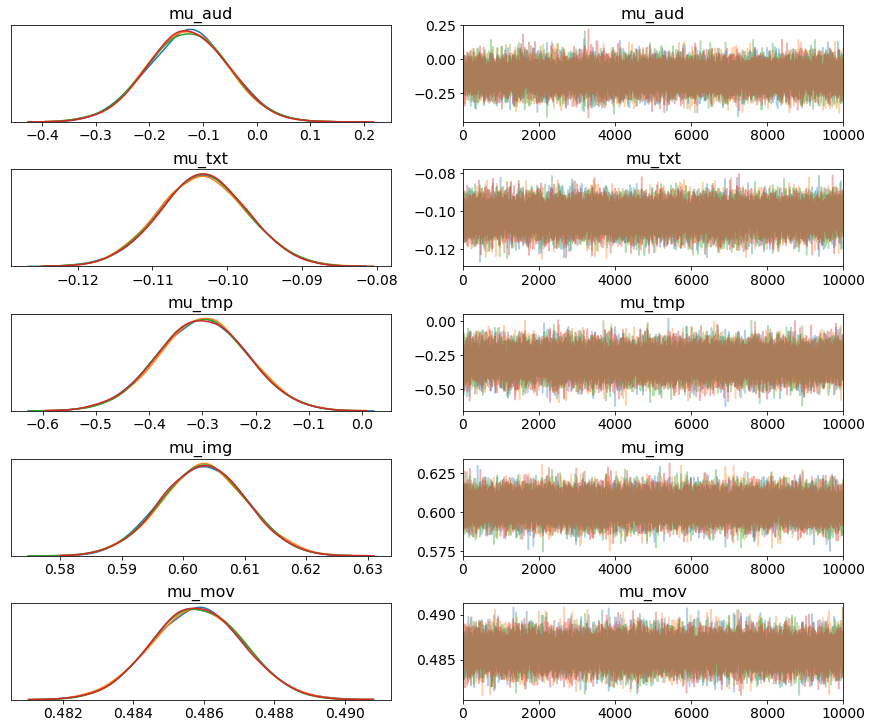

In [17]:
import arviz as az
inference_data = az.from_pystan(posterior=fit) # posterior kw is optional
az.plot_trace(inference_data,var_names=['mu_aud','mu_txt','mu_tmp','mu_img','mu_mov'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13491f710>,
      dtype=object)

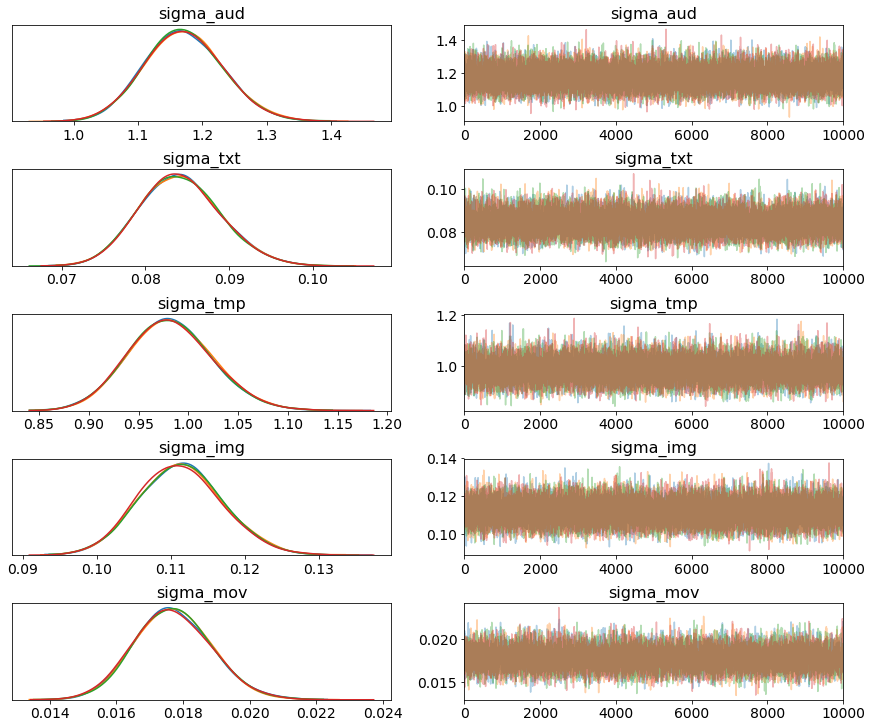

In [18]:
az.plot_trace(inference_data,var_names=['sigma_aud','sigma_txt','sigma_tmp','sigma_img','sigma_mov'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x142c196a0>,
      dtype=object)

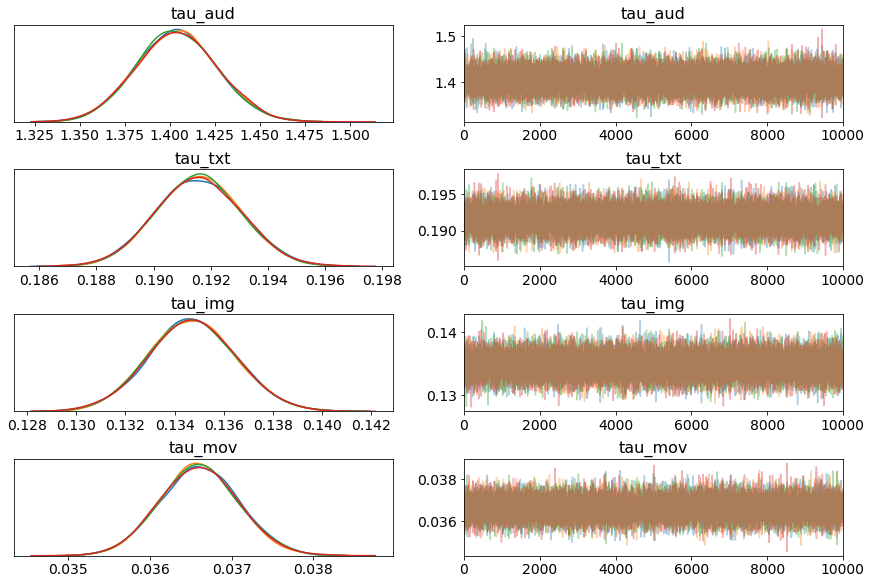

In [19]:
az.plot_trace(inference_data,var_names=['tau_aud','tau_txt','tau_tmp','tau_img','tau_mov'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x143b095f8>,
      dtype=object)

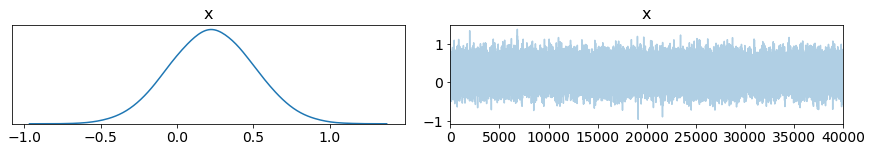

In [20]:
az.plot_trace(fit["eta[23]"])

In [21]:
players_data_all['id'][22]

'spcfoxtv'

In [22]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,25)},style="whitegrid",font_scale=1.7)

In [23]:
external_valid.head()
'landmaz' in list(external_valid.twitch)
str(list(external_valid.loc[external_valid.twitch == 'landmaz'].rankgrp04)[0])

'nan'

In [50]:
manual_may_ranks = {
 'nightsifyy': 'A',
 '1herocs': 'A',
 'caspy': 'A',
 'cjpriku': 'G',
 'clide1d': 'A',
 'colbzz': 'C',
 'dellzorfn': 'B',
 'frownnn': 'A',
 'gdpink': 'A',
 'herovit': 'B',
 'hydrexcs': 'S',
 'ipleadthe5cs': 'A',
 'isopandaman': 'B',
 'kaboosecs': 'S',
 'kelxdd': 'G',
 'landmaz': 'A',
 'masamxne': 'A',
 'mickslammit': 'G',
 'samanthaeg': 'B',
 'tenz': 'S',
 'theia': 'A',
 'tylercheetah': 'B',
 'wholewheatpete': 'A',
 'voltz420': 'C',
 'westcentralzz': 'C',
 'lirimmz': 'B',
 'brine_tv': 'C',
 'crossbar18': 'D',
 'heyitsboz': 'B',
 'a3har': 'B',
 'swazired': 'B',
 'br3ac': 'D',
 'adept_dave': 'B',
 'codsky': 'B',
 'itzace_gg': 'B',
 'dicezzz': 'B',
 'kingbonoboqc': 'B',
 'storfisk': 'C',
 'cok4in': 'B',
 'kimatarokisharo': 'C',
 'r3nch': 'C',
 'iserac': 'C',
 '1mountainog': 'A',
 '1sparx': 'B',
 '2bamboozled': 'B',
 'alejo98vs': 'A',
 'amnesia_cs': 'B',
 'axylus': 'A',
 'benzjamin': 'B',
 'bighurtz': 'D',
 'blunt_af': 'B',
 'bo0mie': 'B',
 'bot_sh4rk': 'B',
 'bratty': 'B',
 'caspy': 'A',
 'chill3k': 'C',
 'chimu90': 'C',
 'cilantro_live': 'B',
 'colbzz': 'C',
 'concuring': 'A',
 'crushingit79': 'B',
 'cryptt': 'B',
 'da_ft': 'B',
 'dellzorfn': 'B',
 'dire_cs': 'A',
 'doctormonsta': 'C',
 'drhippo': 'A',
 'dropdeadlexi': 'C',
 'drrtysal': 'C',
 'frownnn': 'A',
 'gajokerl': 'B',
 'goofplays': 'A',
 'hotsaucek2': 'B',
 'hunt__tv': 'B',
 'immenson': 'C',
 'imskizzy': 'B',
 'isopandaman': 'B',
 'itrxgic': 'C',
 'its_slim_': 'B',
 'itsbunch': 'B',
 'jackpot_usc': 'B',
 'jsetv': 'B',
 'kraytosthegod': 'A',
 'lilgrizz818': 'B',
 'lordnm': 'D',
 'mad3sto': 'B',
 'masonhtv': 'B',
 'mayorsayso': 'A',
 'modernkeyboard': 'D',
 'nerd0cs': 'B',
 'nick_thacker': 'A',
 'omgkam': 'C',
 'oogyl': 'B',
 'oriontaker': 'B',
 'pandacchaos': 'C',
 'passionite': 'B',
 'pattylovesyou': 'B',
 'roguexlimitz': 'D',
 'samanthaeg': 'B',
 'slight___': 'A',
 'smithninjas': 'C',
 'smoakland22': 'C',
 'sw_i_ms': 'B',
 'synge': 'B',
 'syzba': 'A',
 'the_doobie': 'B',
 'thepockypanduh': 'C',
 'tmay': 'B',
 'to3tagz': 'C',
 'ttvnyko': 'C',
 'tuulio': 'B',
 'tylercheetah': 'B',
 'very_classic': 'A',
 'vizzuaal': 'B',
 'vprex': 'B',
 'wholewheatpete': 'A',
 'xmalsz': 'B',
 'xxslayerrulesxx': 'C',
 'yatoyogurt': 'A',
 'zan3rg': 'C',
 'zealyth_': 'D',
 'zigster': 'C',
 'zijuu': 'B',
'piktorial' : 'A',
'realsicko_tv' : 'A',
'red_cyrex' : 'A',
'motm' : 'S',
'lenoncsgo' : 'G' ,
'hello_kaykay' : 'A',
'k3vin_csgo' : 'A',
'retroxox' : 'A',
'minusscs' :  'G',
'malbsmdsaiyajin' : 'G',
'lexcs' : 'G',
'conankun' : 'G',
'hated2k' : 'A',
'inseaniac_tv' : 'G',
'sh0ts' : 'A',
'dooran' : 'A',
'draxido' : 'A',
'krappydaklownjunior': 'A',
'natani_k': 'D',
'animegorls': 'B',
'abcdroid': 'C',
'joshinthebox169': 'A',
'reekris87': 'C',
'deejayfu': 'D',
'runawaychickenx': 'C',
'manzkid': 'B',
'farthammer1sg': 'B',
'n1copz': 'A',
'scorchyybc': 'B',
'josh_ortega': 'C',
'feralcod': 'C',
'fruxc': 'C',
'khemust': 'A',
'spcfoxtv': 'A',
'whitetehshadow': 'B' ,
'allingaming23': 'C',
'jas_cs': 'B',
'verzar6': 'B',
'kirshier': 'B',
'lazy_bum_': 'D' ,
'j9shtv': 'C',
'johnngavinn': 'B',
'josh_swan21': 'C',
'tv_deka': 'A',
'parfilo': 'B',
'zenixxcs': 'B',
'buddahkb': 'B',
'xanxiwnl': 'B',
'nitsua_tv': 'B',
'funies': 'B',
'mr_worthy': 'B',
'mattcdoeyt': 'C',
'thinkkfirst': 'B',
'birdman2642': 'D',
'swifttt_tv': 'C',
'glyyphh': 'B',
'andrhw': 'C',
'genesis_j': 'C',
'1stillmatic': 'B',
'hazardouslive': 'A',
'blairski7': 'A',
 'noxio': 'A',
'ashen_cs': 'A',
'imjynxlive': 'A',
'toyr34': 'S',
'aleksandarhz': 'G',
'kermeytheefrog': 'A',
'sharkie_tv': 'G',
'jmaldocs': 'A',
'las_cs': 'A',
'jewkcs': 'A',
'blakerscs': 'A',
'zaddynguyens': 'A',
'nzer0name': 'A',
'beastbox': 'A',
'lolatyourswag': 'A',
'mfxolddie': 'B' ,
'chqrlslol': 'C' ,
'plutomonium': 'B' ,
'physifyee': 'B' ,
'xtr_nbf': 'B' ,
'tannersorensen': 'B' ,
'alexastro': 'C' ,
'katernum': 'C' ,
'meagan': 'C' ,
'oomoomanoo': 'B' ,
'ec0nica': 'D' ,
'dabestchicken': 'D' ,
'phightme': 'A' ,
'yayooo_tv': 'B' ,
'daseegs': 'D' ,
'tors0_': 'A',
'exc1x': 'B' ,
'persian_tv': 'C' ,
'arzee_cs': 'A' ,
'fakeem': 'B' ,
'snoob_': 'B' ,
'hayon_tv': 'A' ,
'doubleapple': 'B' ,
'zephe': 'B' ,
'lumaaz': 'B' ,
'vzohhck': 'B',
'moroncs': 'A',
'slayerhz': 'A',
'palombatv': 'C',
'moechilla': 'A',
'c0nfusiontv': 'A',
'grxpecs': 'A',
'hellzaoocsgo': 'A',
'hammerna': 'A',
'deadhuntar': 'A',
'ehhspartan': 'A',
'therealflixxy': 'A',
'nicholaspcs': 'A',
'traviskun_': 'B',
'intry': 'A',
'1mannym': 'A',
'zanderd': 'G',
'alert_tv': 'A',
'fenomm': 'G',
'robbyo': 'A',
'cuz1h': 'A',
'crimgame': 'C' ,
'vitobad': 'D' ,
'sotz02': 'D' ,
'msxshots': 'B' ,
'tyler_a_lot': 'C' ,
'jethro_sb': 'C' ,
'tflug': 'B' ,
'nutty_live': 'B' ,
'blique_': 'B' ,
'maskk_tv': 'B',
'theanonymousrory': 'D' ,
'paukbhop': 'C' ,
'professorbeetus': 'D' ,
'chaddypz': 'B',
'realxsg': 'C' ,
'zan0theman0': 'D' ,
'itaroo_bot': 'D' ,
'suplexfps': 'A' ,
'ethxnnnn': 'A' ,
'polaroidnx': 'C' ,
'proteustv': 'B' ,
'daemgg': 'B' ,
'nicxcs': 'B' ,
'hokku': 'B' ,
'xelas_': 'B' ,
'dakzrp': 'B' ,
'shostak': 'C' ,
'daedus': 'C' ,
'rectum_spectrum': 'A',
'scem': 'B' ,
'flippybitsgg': 'D' ,
'humbabeast': 'A' ,
'bunnyisbad': 'A' ,
'mockcs': 'A' ,
'sushizcs': 'C',
'moeseftv': 'B' ,
'xajs': 'B' ,
'namhel_cs': 'D' ,
'mala': 'A'
}

In [51]:
len(manual_may_ranks)

276

In [52]:
skill = []
valid = []
ids = []
meds = []
sel_ids = list(external_valid.twitch)
rank_A = []
may_ranks = []
llik = []


for s in range(players_data['P']):
    ii = players_data_all['id'][s]
    if ii not in sel_ids:
        continue
    lookup = 'eta['+str(s+1)+']'
    superv = 1 if s < players_data['P_obs'] else 0
    niter = len(fit[lookup])

    if ii in list(external_valid.twitch):
        rank1 = str(list(external_valid.loc[external_valid.twitch == ii].rankgrp01)[0])
    else:
        rank1 = 'nan'

    if ii in list(external_valid.twitch):
        rank2 = str(list(external_valid.loc[external_valid.twitch == ii].rankgrp02)[0])
    else:
        rank2 = 'nan'

    if ii in list(external_valid.twitch):
        rank3 = str(list(external_valid.loc[external_valid.twitch == ii].rankgrp03)[0])
    else:
        rank3 = 'nan'
   
    if ii in list(external_valid.twitch):
        rank4 = str(list(external_valid.loc[external_valid.twitch == ii].rankgrp04)[0])
    else:
        rank4 = 'nan'
        

    if rank1 == 'A' or rank2 =='A' or rank3 =='A':
        rank = 1
    else:
        rank = 0
        
    if ii in manual_may_ranks:
        m_rank = manual_may_ranks[ii]
    else:
        m_rank = 'n.a.'
        
    skill.extend(fit[lookup])
    med = np.median(fit[lookup])
    
    valid.extend(list(np.full(niter,superv)))
    ids.extend(list(np.full(niter,ii)))
    meds.extend(list(np.full(niter,med)))
    rank_A.extend(list(np.full(niter,rank)))
    may_ranks.extend(list(np.full(niter,m_rank)))
    llik.extend(fit["lp__"])
    

skill_dat = pd.DataFrame.from_dict({'skill':skill,'twitch':ids,
                                    'valid':valid, 'meds':meds,
                                   'rank_A' : rank_A, 'may_ranks': may_ranks,'llik' : llik})

In [53]:
skill_dat.head()

,skill,twitch,valid,meds,rank_A,may_ranks,llik
0,0.062849,ironman_ts,1,-0.073576,1,n.a.,24913.206288
1,-0.221097,ironman_ts,1,-0.073576,1,n.a.,24904.160580
2,0.228458,ironman_ts,1,-0.073576,1,n.a.,24813.595867
3,0.012190,ironman_ts,1,-0.073576,1,n.a.,24789.746627
4,-0.251494,ironman_ts,1,-0.073576,1,n.a.,24890.931901


In [54]:
len(skill_dat)

17000000

In [55]:
len(set(skill_dat.twitch))

425

In [56]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score

label = list( (skill_dat.rank_A==1) ) 
pred = list(skill_dat.meds)

In [57]:
roc_auc_score(label,pred)

0.893614615836838

In [58]:
from tqdm import tqdm
def optim_thresh(preds, labels):

    best_score = -1
    best_thres = -1
    
    for x in tqdm(np.linspace(min(preds), max(preds), num=999)):

        scr = f1_score(labels, preds >= x)
    
        if scr > best_score:
            best_thres = x
            best_score = scr

    return best_thres

In [59]:
skill_dat_valid = skill_dat.loc[ ( skill_dat["valid"] == 1)  ]
skill_dat_valid_new = skill_dat_valid[["twitch",'skill','rank_A']]
grouped = skill_dat_valid_new.groupby('twitch')
means = grouped.median()
label_valid = list( (means.rank_A==1) ) 
pred_valid = list(means.skill)

In [60]:
auc = roc_auc_score(label_valid,pred_valid)
th_valid = optim_thresh(pred_valid,label_valid)
f1 = f1_score(label_valid,pred_valid>th_valid)
rec = recall_score(label_valid,pred_valid>th_valid)
prc = precision_score(label_valid,pred_valid>th_valid)
print(f'AUC: {auc} F1 {f1} Rec {rec} Prec {prc} ')

100%|██████████| 999/999 [00:00<00:00, 2283.99it/s]

AUC: 0.7974603174603174 F1 0.7543859649122807 Rec 0.86 Prec 0.671875 


In [61]:
skill_dat_train = skill_dat.loc[ (skill_dat["valid"] == 0 ) ]
skill_dat_train_new = skill_dat_train[["twitch",'skill','rank_A']]
grouped = skill_dat_train_new.groupby('twitch')
means = grouped.median()
label_train = list( (means.rank_A==1) ) 
pred_train = list(means.skill)

In [62]:
auc = roc_auc_score(label_train,pred_train)
th_train = optim_thresh(pred_train,label_train)
f1 = f1_score(label_train,pred_train>th_train)
rec = recall_score(label_train,pred_train>th_train)
prc = precision_score(label_train,pred_train>th_train)
print(f'AUC: {auc} F1 {f1} Rec {rec} Prec {prc} ')

100%|██████████| 999/999 [00:00<00:00, 1931.83it/s]

AUC: 0.9231902356902357 F1 0.8106060606060606 Rec 0.8106060606060606 Prec 0.8106060606060606 


In [63]:
skill_dat = skill_dat.sort_values(by='meds', ascending=False)

In [64]:
top = np.quantile(list(skill_dat.meds),0.9)
bot = np.quantile(list(skill_dat.meds),0.1)
print(f'Top {top} Bottom {bot}')
skill_dat_top = skill_dat.loc[ (skill_dat["meds"] > top ) ]
skill_dat_bot = skill_dat.loc[ (skill_dat["meds"] < bot ) ]

Top 0.46079212464922126 Bottom -0.18264554687761603


In [65]:
len(skill_dat_bot.groupby('twitch'))

42

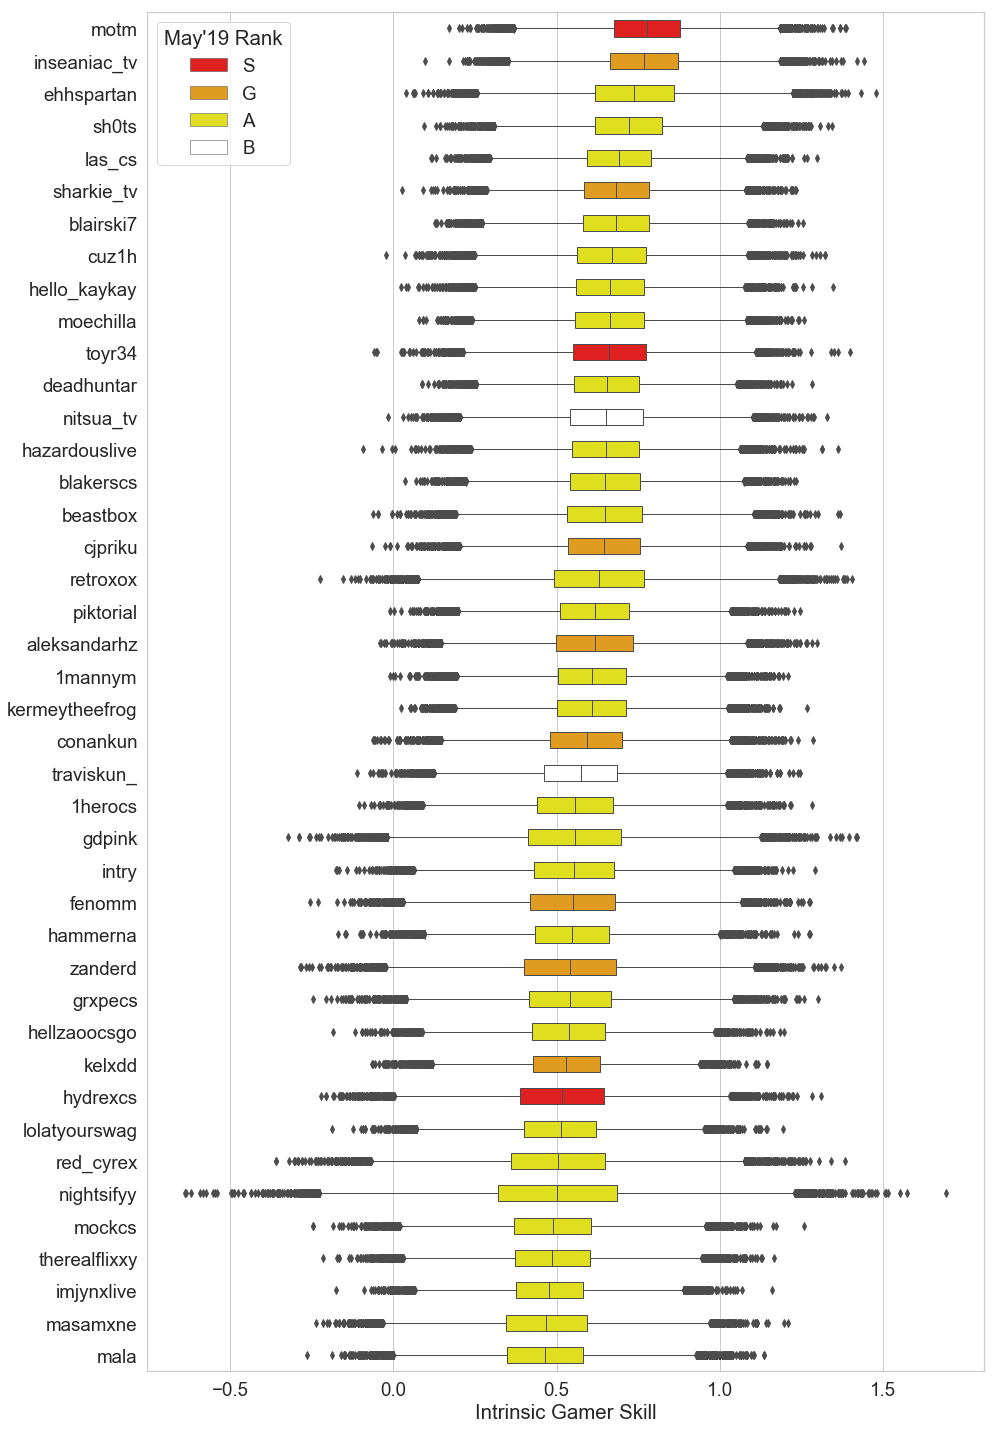

In [66]:
pal = {'S':'red', 'G': 'orange', 'A': 'yellow', 'n.a.': 'maroon', 'B': 'white', 'C':'gray'}
ax = sns.boxplot(x="skill", y="twitch", hue="may_ranks",palette=pal,
                 data=skill_dat_top, linewidth = 1, width = 0.5, dodge=False,
                 orient='h')
ax.set_ylabel('')
ax.set_xlabel('Intrinsic Gamer Skill')
l = ax.legend()
l.set_title("May'19 Rank")

In [69]:
from scipy.stats import spearmanr, pearsonr, kendalltau

skill_dat_top_new = skill_dat_top[['twitch','skill','may_ranks']]
skill_dat_top_new['may_ranks'].replace( {'A': 0, 'B': 0, 'C': 0, 'D': 0,'S':1,'G':1},inplace=True)
grouped = skill_dat_top_new.groupby(['twitch'])
means = grouped.median()
label = list( means.may_ranks ) 
pred = list(means.skill)
kendalltau(label,pred)

KendalltauResult(correlation=0.11626842360313606, pvalue=0.36751665429744573)

In [70]:
means.head()

,skill,may_ranks
twitch,,
1herocs,0.555790,0
1mannym,0.607797,0
aleksandarhz,0.616022,1
beastbox,0.647511,0
blairski7,0.680614,0


In [71]:
len(label)

42

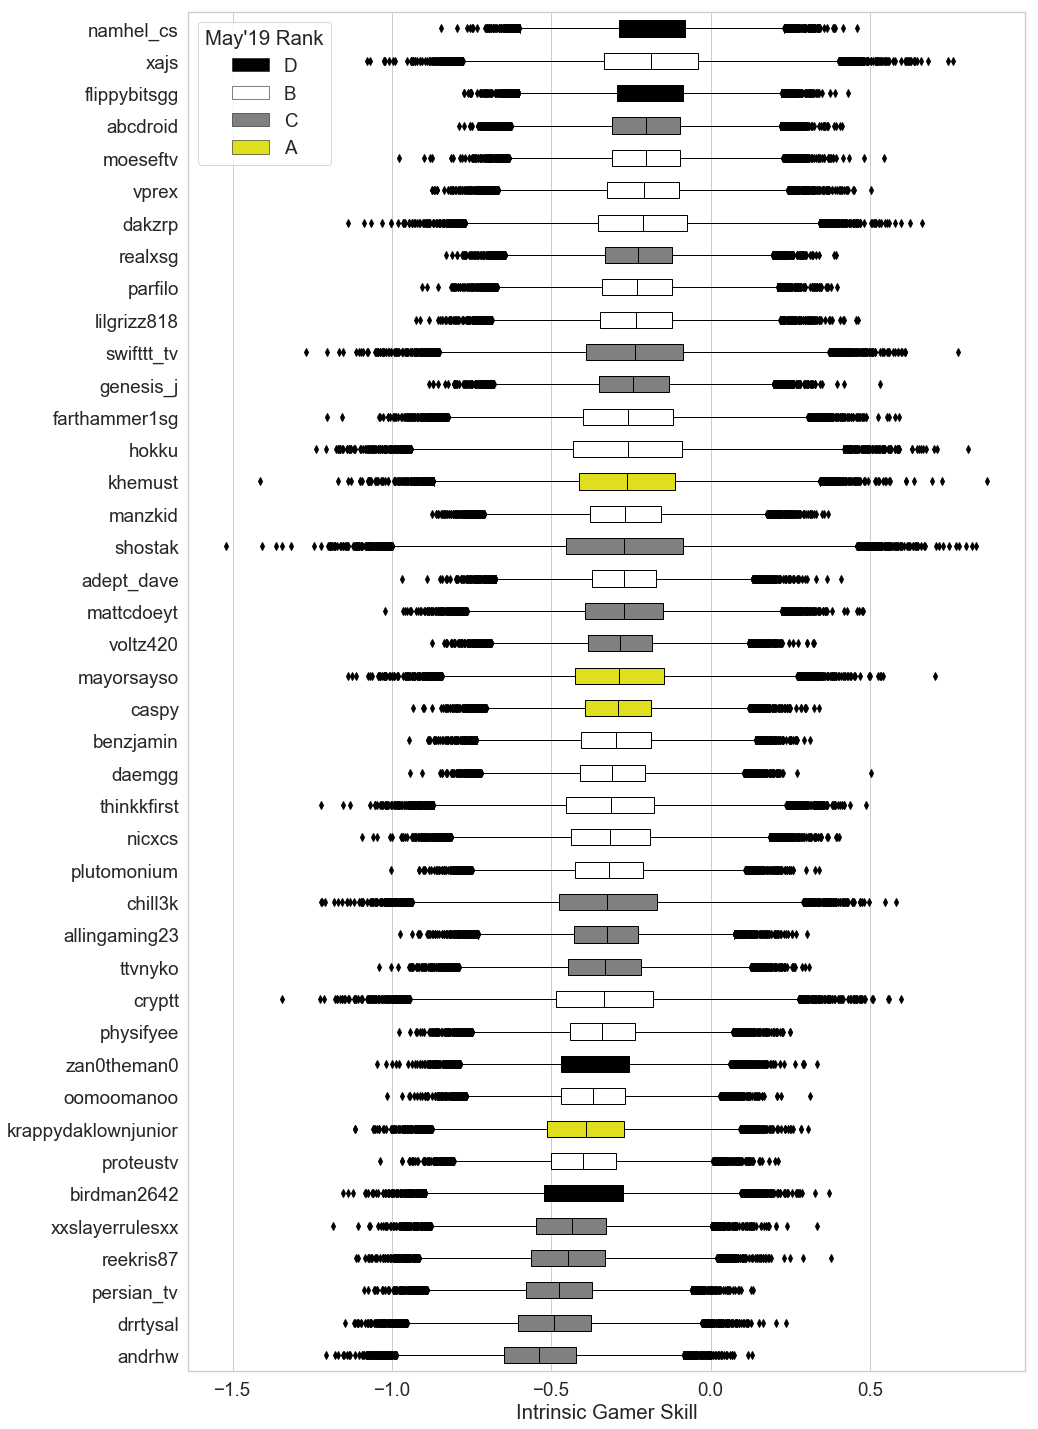

In [72]:
pal = {'D': 'black', 'A': 'yellow', 'n.a.': 'maroon', 'B': 'white', 'C':'gray'}
ax = sns.boxplot(x="skill", y="twitch", hue="may_ranks",palette=pal,
                 data=skill_dat_bot, linewidth = 1, width = 0.5, dodge=False,
                 orient='h')
ax.set_ylabel('')
ax.set_xlabel('Intrinsic Gamer Skill')
l = ax.legend()
l.set_title("May'19 Rank")

In [73]:
th_fp = np.quantile(list(skill_dat.meds),0.5)
th_fp

0.08607602617655524

In [74]:
skill_dat_fp = skill_dat.loc[ (skill_dat["meds"] > th_fp) & (skill_dat["rank_A"] == 0 ) ]
skill_dat_fp.head()

,skill,twitch,valid,meds,rank_A,may_ranks,llik
2280000,0.344093,its_slim_,1,0.449201,0,B,24913.206288
2319998,0.671076,its_slim_,1,0.449201,0,B,24864.104724
2319997,0.353498,its_slim_,1,0.449201,0,B,24777.849706
2293329,0.558589,its_slim_,1,0.449201,0,B,24910.755185
2293336,0.653563,its_slim_,1,0.449201,0,B,24833.272180


In [75]:
len(skill_dat_fp.groupby('twitch'))

63

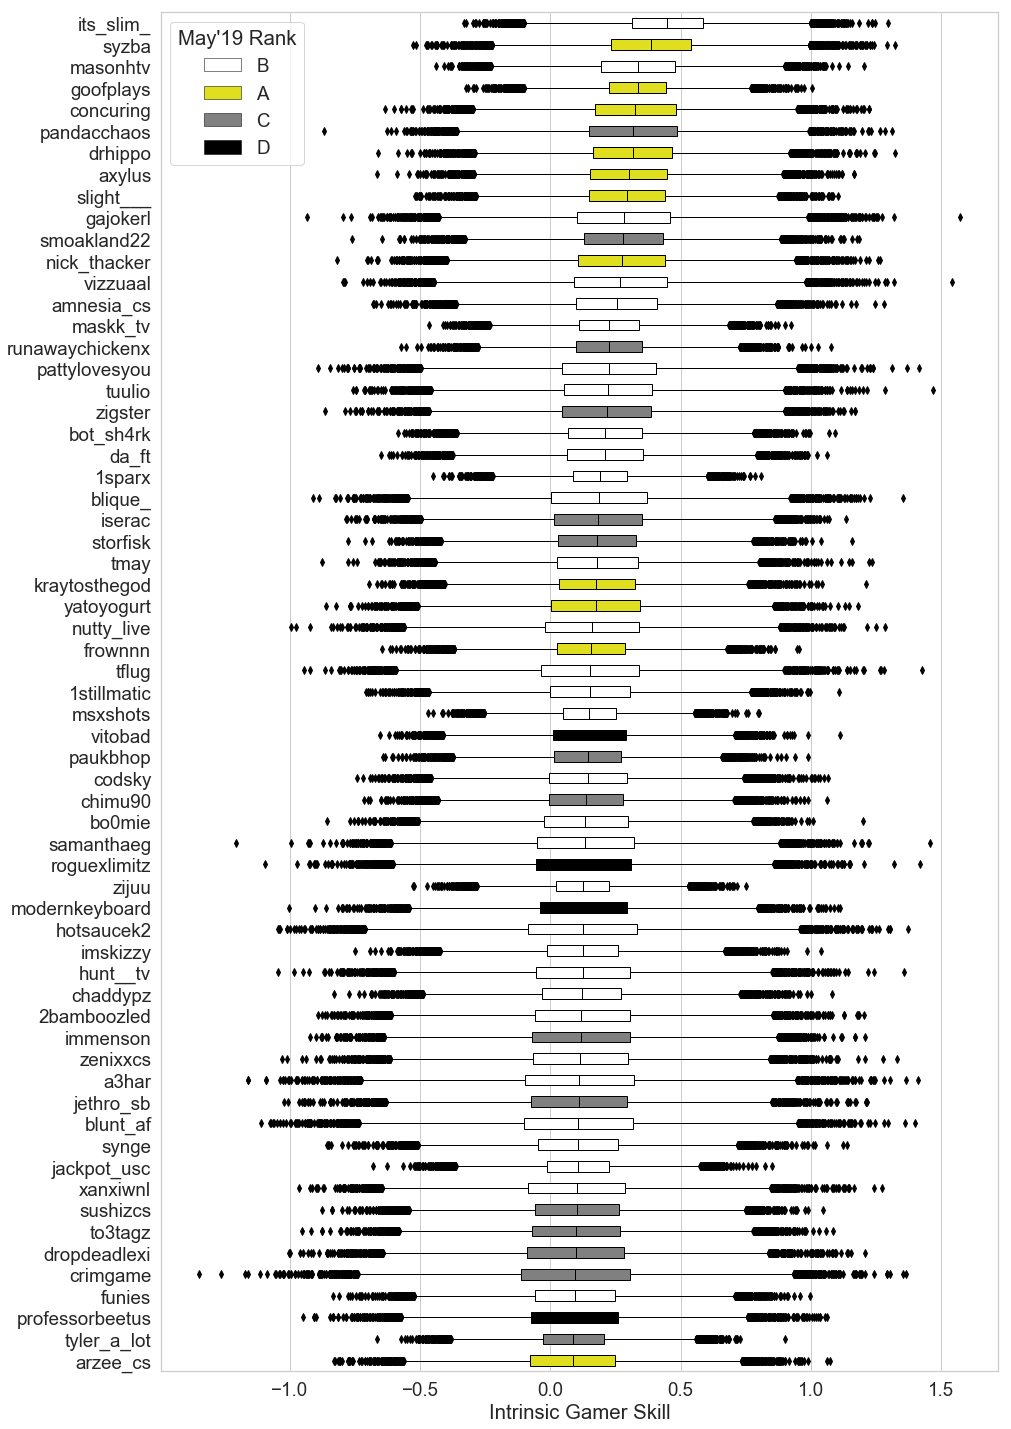

In [76]:
pal = { 'A': 'yellow', 'n.a.': 'maroon', 'B': 'white', 'C':'gray', 'D':'black',}
ax = sns.boxplot(x="skill", y="twitch", hue="may_ranks",palette=pal,
                 data=skill_dat_fp, linewidth = 1, width = 0.5, dodge=False,
                 orient='h')
ax.set_ylabel('')
ax.set_xlabel('Intrinsic Gamer Skill')
l = ax.legend()
l.set_title("May'19 Rank")

In [77]:
from scipy.stats import spearmanr, pearsonr, kendalltau
import numpy as np

skill_dat_fp_new = skill_dat_fp[['twitch','skill','may_ranks']]
skill_dat_fp_new['may_ranks'].replace( {'A': 1, 'B': 0, 'C': 0, 'D': 0},inplace=True)
skill_dat_fp_new = pd.concat([skill_dat_fp_new[['twitch']], skill_dat_fp_new[['may_ranks','skill']].astype(float)], 
                             axis=1)
grouped = skill_dat_fp_new.groupby(['twitch'])
means = grouped.median()
label = list( means.may_ranks ) 
pred = list( means.skill )
kendalltau(label,pred)

KendalltauResult(correlation=0.297084854612375, pvalue=0.004475957617770458)

In [78]:
for el in set(skill_dat_bot.twitch):
    if el not in manual_may_ranks:
        ss = external_valid.loc[lambda external_valid: external_valid.twitch == el,:]
        print(el, 'https://play.esea.net/users/' + str(list(ss.userid)[0]))

In [79]:
for el in set(skill_dat_top.twitch):
    if el not in manual_may_ranks:
        ss = external_valid.loc[lambda external_valid: external_valid.twitch == el,:]
        print(el, 'https://play.esea.net/users/' + str(list(ss.userid)[0]))

In [80]:
for el in set(skill_dat_fp.twitch):
    if el not in manual_may_ranks:
        ss = external_valid.loc[lambda external_valid: external_valid.twitch == el,:]
        print(el, 'https://play.esea.net/users/' + str(list(ss.userid)[0]))